In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [2]:
original_image_dir = './Jaws_labeled_images'
train_image_dir = '/blue/bsc4892/adrian.l/Jaws_augmented_images'
valid_image_dir = '/blue/bsc4892/adrian.l/Jaws/Jaws_validation_images'

In [3]:
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3 
num_classes = 18
batch_size = 32

In [19]:
train_images = image_dataset_from_directory(
    train_image_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', image_size=(resized_height ,
    resized_width ), batch_size=batch_size, shuffle=True, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)
print(train_images)

class_names = train_images.class_names

Found 4780 files belonging to 18 classes.
<BatchDataset shapes: ((None, 224, 224, 3), (None, 18)), types: (tf.float32, tf.float32)>


In [20]:
valid_images = image_dataset_from_directory(
    valid_image_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', image_size=(resized_height ,
    resized_width ), batch_size=32, shuffle=True, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)
print(valid_images)

Found 23 files belonging to 18 classes.
<BatchDataset shapes: ((None, 224, 224, 3), (None, 18)), types: (tf.float32, tf.float32)>


## CNN on original data

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') 
])

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the training dataset 
train_images = image_dataset_from_directory(
    original_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,  
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    original_image_dir,
    validation_split=0.2,  
    subset="validation",
    seed=42,  
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True  
)

# Ensure the train_images dataset is suitable for model training
train_images = train_images.prefetch(buffer_size=32)

Found 108 files belonging to 18 classes.
Using 87 files for training.
Found 108 files belonging to 18 classes.
Using 21 files for validation.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
    train_images,  
    epochs=10,  
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/10


2024-04-23 15:46:50.202879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-04-23 15:46:51.987087: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 8s 485ms/step - loss: 787.4171 - accuracy: 0.1609 - val_loss: 347.5313 - val_accuracy: 0.0476
Epoch 2/10
3/3 [==============================] - 4s 607ms/step - loss: 169.8788 - accuracy: 0.1034 - val_loss: 21.2402 - val_accuracy: 0.3810
Epoch 3/10
3/3 [==============================] - 5s 908ms/step - loss: 17.9841 - accuracy: 0.1954 - val_loss: 7.3969 - val_accuracy: 0.0476
Epoch 4/10
3/3 [==============================] - 4s 460ms/step - loss: 3.4849 - accuracy: 0.3908 - val_loss: 2.3046 - val_accuracy: 0.3333
Epoch 5/10
3/3 [==============================] - 5s 767ms/step - loss: 0.9072 - accuracy: 0.8161 - val_loss: 3.2223 - val_accuracy: 0.3333
Epoch 6/10
3/3 [==============================] - 4s 610ms/step - loss: 0.3664 - accuracy: 0.9310 - val_loss: 5.4373 - val_accuracy: 0.2857
Epoch 7/10
3/3 [==============================] - 4s 396ms/step - loss: 0.1968 - accuracy: 0.9770 - val_loss: 4.3730 - val_accuracy: 0.2857
Epoch 8/10
3/3 [=======

In [12]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 1s 784ms/step - loss: 2.3046 - accuracy: 0.3333
Validation loss: 2.3045897483825684
Validation accuracy: 0.3333333432674408


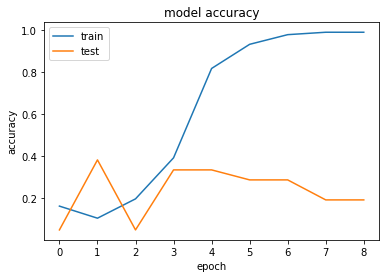

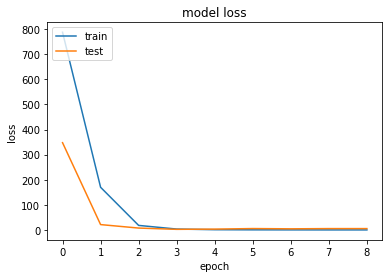

In [13]:
from helpers_plot_history import plot_history
plot_history(history)

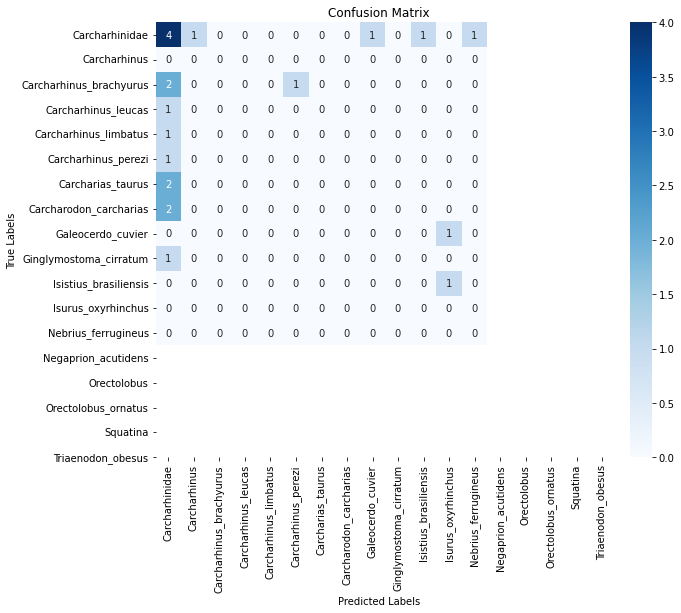

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## CNN on augmented images 

In [22]:
# Using the same model but augmented images

In [23]:
# Load the training dataset 
train_images = image_dataset_from_directory(
    train_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,  
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    valid_image_dir,
    seed=42,  
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True  
)

# Ensure the train_images dataset is suitable for model training
train_images = train_images.prefetch(buffer_size=32)

Found 4780 files belonging to 18 classes.
Found 23 files belonging to 18 classes.


In [24]:
# Train the model
history = model.fit(
    train_images,  
    epochs=10,  
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/10
150/150 [==============================] - 103s 660ms/step - loss: 1.8894 - accuracy: 0.6232 - val_loss: 2.1492 - val_accuracy: 0.3478
Epoch 2/10
150/150 [==============================] - 60s 380ms/step - loss: 1.4063 - accuracy: 0.6548 - val_loss: 2.2684 - val_accuracy: 0.3478
Epoch 3/10
150/150 [==============================] - 55s 346ms/step - loss: 1.0927 - accuracy: 0.7029 - val_loss: 2.6826 - val_accuracy: 0.3043
Epoch 4/10
150/150 [==============================] - 54s 348ms/step - loss: 0.7146 - accuracy: 0.7814 - val_loss: 3.0223 - val_accuracy: 0.2609
Epoch 5/10
150/150 [==============================] - 50s 317ms/step - loss: 0.4859 - accuracy: 0.8594 - val_loss: 4.3234 - val_accuracy: 0.2609
Epoch 6/10
150/150 [==============================] - 48s 300ms/step - loss: 0.4368 - accuracy: 0.8762 - val_loss: 3.2237 - val_accuracy: 0.3478


In [25]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 1s 992ms/step - loss: 2.1492 - accuracy: 0.3478
Validation loss: 2.1492393016815186
Validation accuracy: 0.3478260934352875


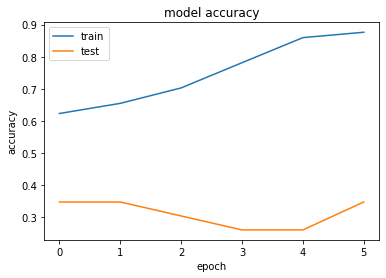

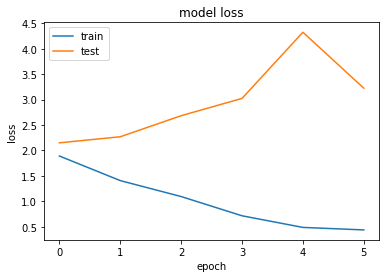

In [26]:
plot_history(history)

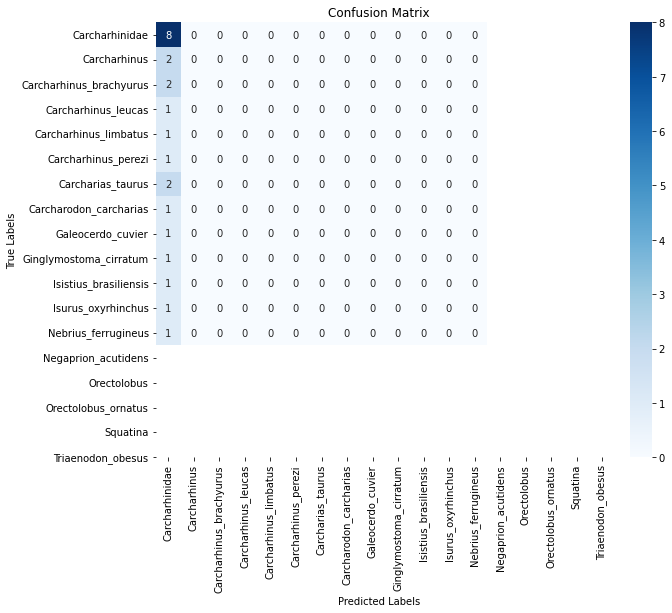

In [27]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Transfer Learning on Original Data

### MobileNetV2

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D


In [29]:
# Load the base MobileNetV2 model with weights pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [30]:
# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Load and preprocess the data
train_images = image_dataset_from_directory(
    original_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

val_ds = image_dataset_from_directory(
    original_image_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Prefetch data
train_images = train_images.prefetch(buffer_size=32)

Found 108 files belonging to 18 classes.
Using 87 files for training.
Found 108 files belonging to 18 classes.
Using 21 files for validation.


In [33]:
# Early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_images,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/10
3/3 [==============================] - 6s 655ms/step - loss: 3.9451 - accuracy: 0.0460 - val_loss: 3.1586 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 4s 317ms/step - loss: 3.2598 - accuracy: 0.1034 - val_loss: 2.7598 - val_accuracy: 0.1429
Epoch 3/10
3/3 [==============================] - 3s 368ms/step - loss: 2.8437 - accuracy: 0.1954 - val_loss: 2.6802 - val_accuracy: 0.3810
Epoch 4/10
3/3 [==============================] - 5s 377ms/step - loss: 2.5458 - accuracy: 0.3103 - val_loss: 2.8114 - val_accuracy: 0.3810
Epoch 5/10
3/3 [==============================] - 6s 560ms/step - loss: 2.3505 - accuracy: 0.3908 - val_loss: 2.9175 - val_accuracy: 0.3810
Epoch 6/10
3/3 [==============================] - 3s 250ms/step - loss: 2.3438 - accuracy: 0.3563 - val_loss: 2.9396 - val_accuracy: 0.3810
Epoch 7/10
3/3 [==============================] - 5s 450ms/step - loss: 2.4471 - accuracy: 0.3448 - val_loss: 2.9411 - val_accuracy: 0.3810
Epoch 8/10
3/3 [

In [34]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 0s 417ms/step - loss: 2.6802 - accuracy: 0.3810
Validation loss: 2.6802151203155518
Validation accuracy: 0.380952388048172


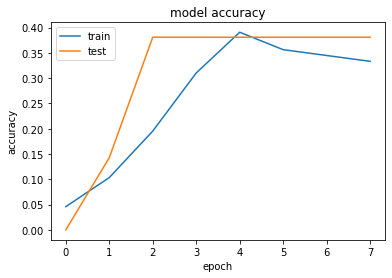

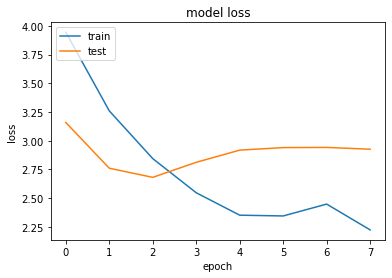

In [35]:
plot_history(history)

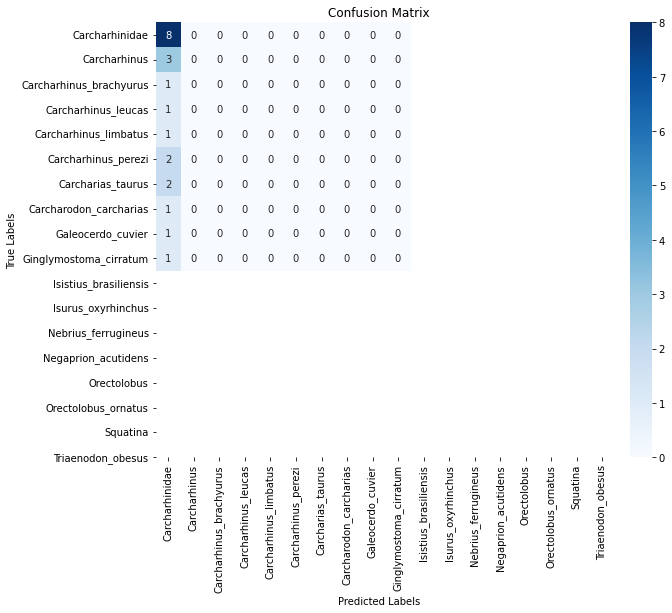

In [36]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ResNet50

In [37]:
from tensorflow.keras.applications import ResNet50


In [38]:
# Load the base ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [39]:
# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Load and preprocess the data
train_images = image_dataset_from_directory(
    original_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

val_ds = image_dataset_from_directory(
    original_image_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Prefetch data
train_images = train_images.prefetch(buffer_size=32)

Found 108 files belonging to 18 classes.
Using 87 files for training.
Found 108 files belonging to 18 classes.
Using 21 files for validation.


In [42]:
# Train the model
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/20
3/3 [==============================] - 6s 800ms/step - loss: 3.8606 - accuracy: 0.0460 - val_loss: 2.7755 - val_accuracy: 0.0476
Epoch 2/20
3/3 [==============================] - 4s 621ms/step - loss: 2.7103 - accuracy: 0.1839 - val_loss: 2.5696 - val_accuracy: 0.3810
Epoch 3/20
3/3 [==============================] - 3s 274ms/step - loss: 2.3959 - accuracy: 0.2874 - val_loss: 2.6786 - val_accuracy: 0.3810
Epoch 4/20
3/3 [==============================] - 3s 287ms/step - loss: 2.3450 - accuracy: 0.4023 - val_loss: 2.7233 - val_accuracy: 0.3810
Epoch 5/20
3/3 [==============================] - 6s 383ms/step - loss: 2.0585 - accuracy: 0.3908 - val_loss: 2.7303 - val_accuracy: 0.3333
Epoch 6/20
3/3 [==============================] - 4s 703ms/step - loss: 1.8494 - accuracy: 0.4483 - val_loss: 2.7393 - val_accuracy: 0.3333
Epoch 7/20
3/3 [==============================] - 5s 716ms/step - loss: 1.7910 - accuracy: 0.4483 - val_loss: 2.7347 - val_accuracy: 0.2857


In [43]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 1s 641ms/step - loss: 2.5696 - accuracy: 0.3810
Validation loss: 2.5696041584014893
Validation accuracy: 0.380952388048172


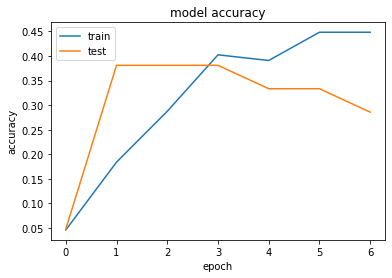

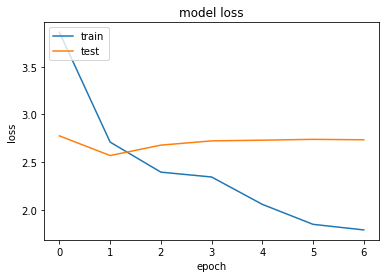

In [44]:
plot_history(history)

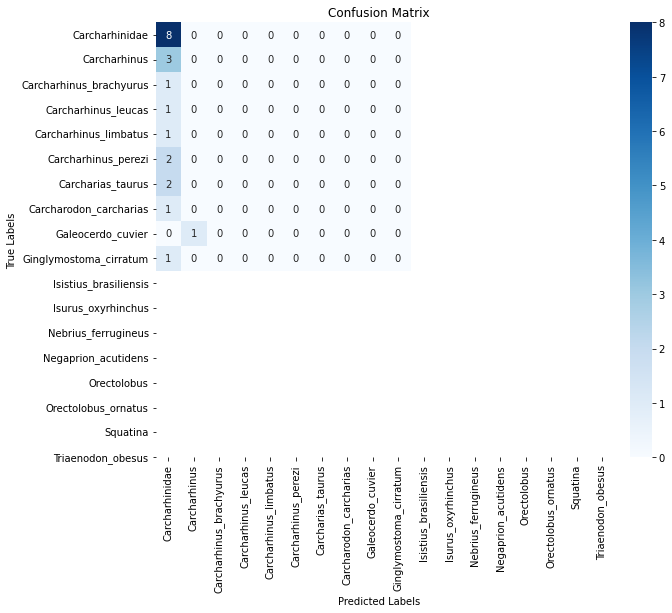

In [45]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### VGG16

In [46]:
from tensorflow.keras.applications import VGG16


In [47]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [48]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Replace num_classes with your actual number of classes
])

In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Load and preprocess the data
train_images = image_dataset_from_directory(
    original_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

val_ds = image_dataset_from_directory(
    original_image_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Prefetch data
train_images = train_images.prefetch(buffer_size=32)

Found 108 files belonging to 18 classes.
Using 87 files for training.
Found 108 files belonging to 18 classes.
Using 21 files for validation.


In [51]:
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/20
3/3 [==============================] - 6s 973ms/step - loss: 9.2567 - accuracy: 0.1379 - val_loss: 5.9640 - val_accuracy: 0.0952
Epoch 2/20
3/3 [==============================] - 4s 343ms/step - loss: 7.4014 - accuracy: 0.1494 - val_loss: 5.2271 - val_accuracy: 0.0952
Epoch 3/20
3/3 [==============================] - 4s 531ms/step - loss: 7.1059 - accuracy: 0.1724 - val_loss: 5.1402 - val_accuracy: 0.0952
Epoch 4/20
3/3 [==============================] - 4s 306ms/step - loss: 7.7107 - accuracy: 0.1724 - val_loss: 5.3233 - val_accuracy: 0.2381
Epoch 5/20
3/3 [==============================] - 4s 526ms/step - loss: 6.7083 - accuracy: 0.1494 - val_loss: 5.5111 - val_accuracy: 0.2857
Epoch 6/20
3/3 [==============================] - 5s 486ms/step - loss: 6.3875 - accuracy: 0.2414 - val_loss: 5.5898 - val_accuracy: 0.3333
Epoch 7/20
3/3 [==============================] - 4s 268ms/step - loss: 6.6996 - accuracy: 0.2874 - val_loss: 5.5885 - val_accuracy: 0.3333
Epoch 8/20
3/3 [====

In [52]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 0s 415ms/step - loss: 5.1402 - accuracy: 0.0952
Validation loss: 5.140194416046143
Validation accuracy: 0.095238097012043


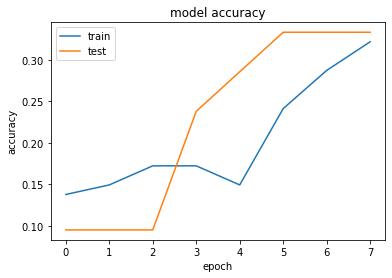

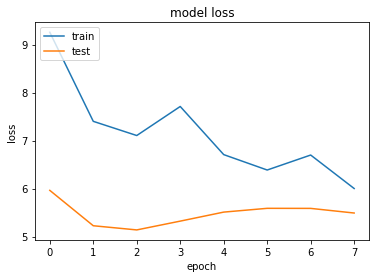

In [53]:
plot_history(history)

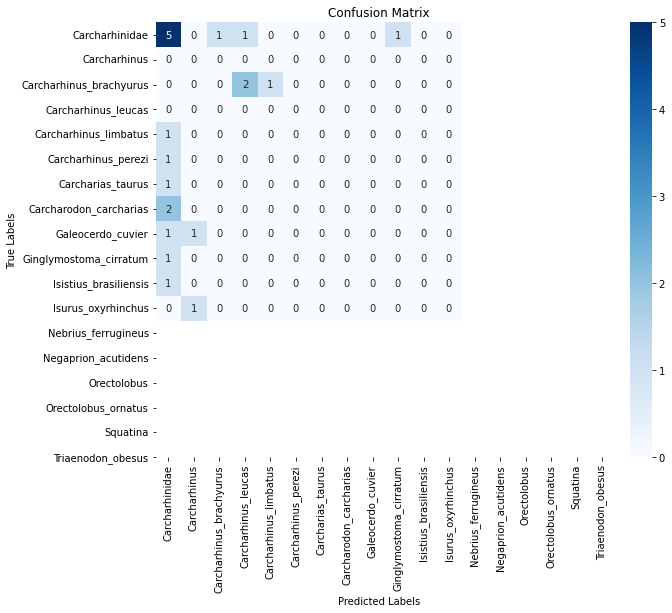

In [54]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Transfer Learning on augmented data

### MobileNetV2

In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D


In [56]:
# Load the base MobileNetV2 model with weights pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [57]:
# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

In [58]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
# Load the training dataset 
train_images = image_dataset_from_directory(
    train_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,  
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    valid_image_dir,
    seed=42,  
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True  
)

# Ensure the train_images dataset is suitable for model training
train_images = train_images.prefetch(buffer_size=32)

Found 4780 files belonging to 18 classes.
Found 23 files belonging to 18 classes.


In [60]:
# Early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_images,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/10
150/150 [==============================] - 59s 370ms/step - loss: 1.7741 - accuracy: 0.6006 - val_loss: 2.6612 - val_accuracy: 0.3478
Epoch 2/10
150/150 [==============================] - 44s 277ms/step - loss: 1.4801 - accuracy: 0.6496 - val_loss: 2.6088 - val_accuracy: 0.3478
Epoch 3/10
150/150 [==============================] - 57s 355ms/step - loss: 1.3873 - accuracy: 0.6540 - val_loss: 2.7143 - val_accuracy: 0.3478
Epoch 4/10
150/150 [==============================] - 61s 374ms/step - loss: 1.3437 - accuracy: 0.6603 - val_loss: 2.6730 - val_accuracy: 0.3478
Epoch 5/10
150/150 [==============================] - 59s 368ms/step - loss: 1.2876 - accuracy: 0.6607 - val_loss: 2.7571 - val_accuracy: 0.3478
Epoch 6/10
150/150 [==============================] - 46s 277ms/step - loss: 1.2447 - accuracy: 0.6709 - val_loss: 2.7358 - val_accuracy: 0.3478
Epoch 7/10
150/150 [==============================] - 66s 415ms/step - loss: 1.2084 - accuracy: 0.6718 - val_loss: 2.7072 - val_ac

In [61]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 1s 690ms/step - loss: 2.6088 - accuracy: 0.3478
Validation loss: 2.6088428497314453
Validation accuracy: 0.3478260934352875


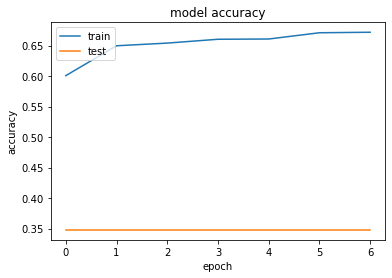

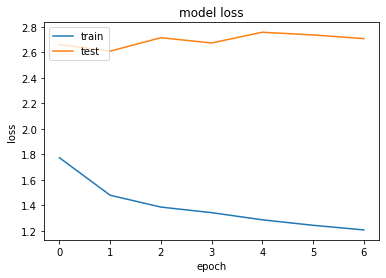

In [62]:
plot_history(history)

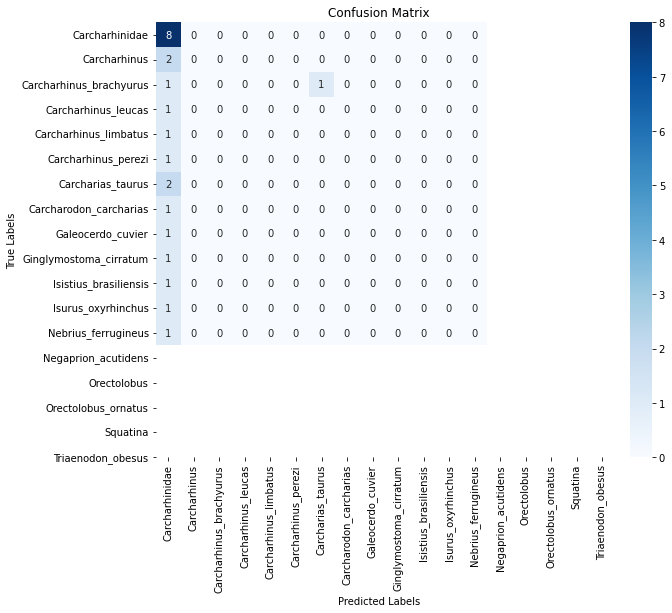

In [63]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ResNet50

In [64]:
from tensorflow.keras.applications import ResNet50


In [65]:
# Load the base ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [66]:
# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

In [67]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
# Load the training dataset 
train_images = image_dataset_from_directory(
    train_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,  
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    valid_image_dir,
    seed=42,  
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True  
)

# Ensure the train_images dataset is suitable for model training
train_images = train_images.prefetch(buffer_size=32)

Found 4780 files belonging to 18 classes.
Found 23 files belonging to 18 classes.


In [70]:
# Train the model
history = model.fit(
    train_images,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/10
150/150 [==============================] - 67s 423ms/step - loss: 1.0740 - accuracy: 0.7094 - val_loss: 2.9714 - val_accuracy: 0.3478
Epoch 2/10
150/150 [==============================] - 70s 451ms/step - loss: 0.6573 - accuracy: 0.8017 - val_loss: 2.9066 - val_accuracy: 0.3478
Epoch 3/10
150/150 [==============================] - 68s 428ms/step - loss: 0.4345 - accuracy: 0.8753 - val_loss: 3.0892 - val_accuracy: 0.3043
Epoch 4/10
150/150 [==============================] - 48s 305ms/step - loss: 0.2975 - accuracy: 0.9195 - val_loss: 3.0247 - val_accuracy: 0.3043
Epoch 5/10
150/150 [==============================] - 58s 358ms/step - loss: 0.2132 - accuracy: 0.9462 - val_loss: 3.2527 - val_accuracy: 0.3043
Epoch 6/10
150/150 [==============================] - 55s 358ms/step - loss: 0.1615 - accuracy: 0.9594 - val_loss: 3.1634 - val_accuracy: 0.3043
Epoch 7/10
150/150 [==============================] - 61s 380ms/step - loss: 0.1300 - accuracy: 0.9701 - val_loss: 3.1581 - val_ac

In [71]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 1s 680ms/step - loss: 2.9066 - accuracy: 0.3478
Validation loss: 2.906602382659912
Validation accuracy: 0.3478260934352875


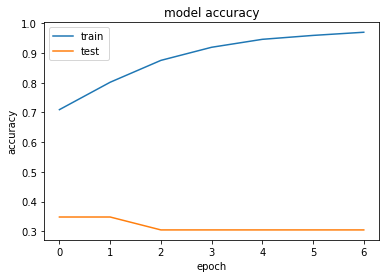

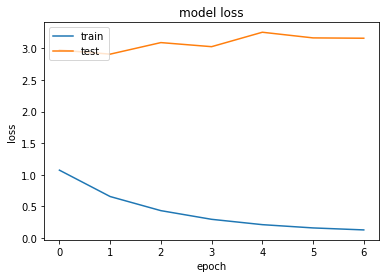

In [72]:
plot_history(history)

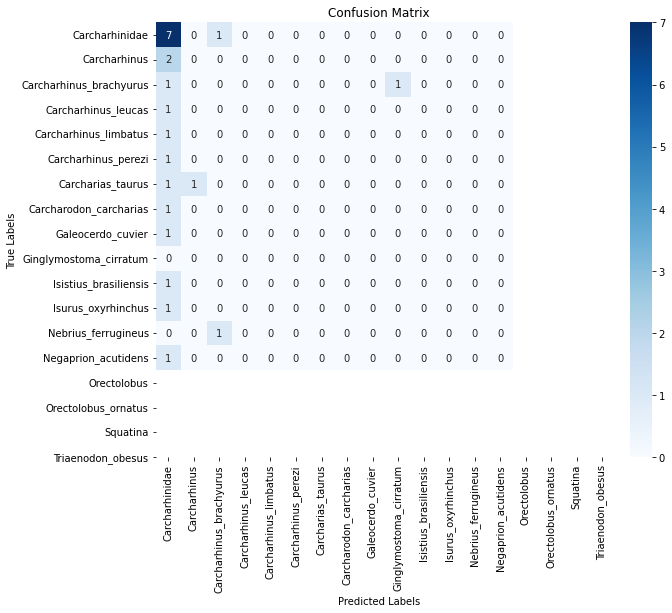

In [73]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### VGG16

In [74]:
from tensorflow.keras.applications import VGG16

In [75]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

In [76]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Replace num_classes with your actual number of classes
])

In [77]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
# Load the training dataset 
train_images = image_dataset_from_directory(
    train_image_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=batch_size,  
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    valid_image_dir,
    seed=42,  
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True  
)

# Ensure the train_images dataset is suitable for model training
train_images = train_images.prefetch(buffer_size=32)

Found 4780 files belonging to 18 classes.
Found 23 files belonging to 18 classes.


In [79]:
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

Epoch 1/20
150/150 [==============================] - 66s 405ms/step - loss: 4.5342 - accuracy: 0.4780 - val_loss: 4.4872 - val_accuracy: 0.3478
Epoch 2/20
150/150 [==============================] - 58s 357ms/step - loss: 2.1361 - accuracy: 0.5745 - val_loss: 3.7675 - val_accuracy: 0.4348
Epoch 3/20
150/150 [==============================] - 59s 375ms/step - loss: 1.3417 - accuracy: 0.6559 - val_loss: 3.4623 - val_accuracy: 0.4348
Epoch 4/20
150/150 [==============================] - 59s 363ms/step - loss: 0.9829 - accuracy: 0.7109 - val_loss: 3.4246 - val_accuracy: 0.4348
Epoch 5/20
150/150 [==============================] - 44s 275ms/step - loss: 0.8057 - accuracy: 0.7556 - val_loss: 3.4175 - val_accuracy: 0.4348
Epoch 6/20
150/150 [==============================] - 39s 243ms/step - loss: 0.6388 - accuracy: 0.8025 - val_loss: 3.3955 - val_accuracy: 0.4348
Epoch 7/20
150/150 [==============================] - 37s 237ms/step - loss: 0.5465 - accuracy: 0.8301 - val_loss: 3.5718 - val_ac

In [80]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

1/1 [==============================] - 0s 467ms/step - loss: 3.3955 - accuracy: 0.4348
Validation loss: 3.3955118656158447
Validation accuracy: 0.43478259444236755


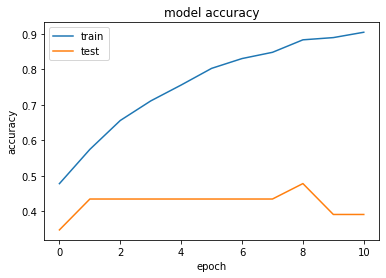

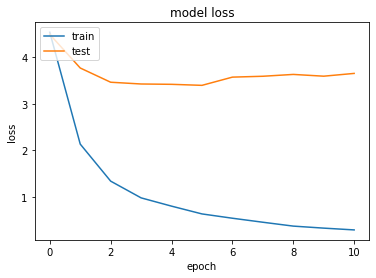

In [81]:
plot_history(history)

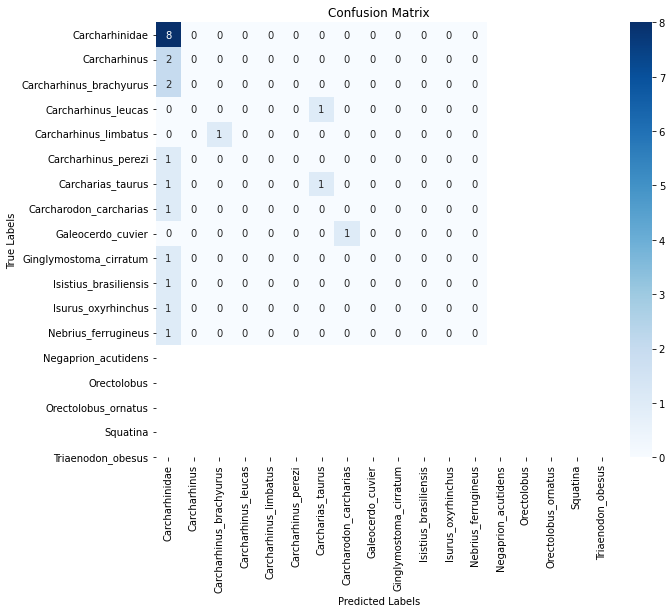

In [82]:
val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
true_labels = np.concatenate([y.numpy() for _, y in val_ds])
true_labels = np.argmax(true_labels, axis=1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Unsupervised learning

In [83]:
from tensorflow.keras.layers import UpSampling2D, Input, Conv2DTranspose
from tensorflow.keras.models import Model


In [84]:
# Define the encoder part of the autoencoder
input_img = Input(shape=(224, 224, 3))  # Adapt this if using `channels_first` image data format

In [85]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder part of the autoencoder
x = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
flatten_layer = Flatten()
encoded_flatten = flatten_layer(encoded)
encoder = Model(inputs=input_img, outputs=encoded_flatten)


In [86]:
# Load your data
train_images = image_dataset_from_directory(
    original_image_dir,
    label_mode=None,  # No labels needed as this is unsupervised
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 108 files belonging to 1 classes.


In [87]:
# Normalize images to [0, 1] to match the sigmoid activation in the decoder output
normalized_images = train_images.map(lambda x: (x / 255.0, x / 255.0))  # Set x as both input and target
normalized_images = normalized_images.prefetch(buffer_size=tf.data.AUTOTUNE)

In [88]:
# Train the autoencoder
history = autoencoder.fit(
    normalized_images,
    epochs=50,
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
)

Epoch 1/50
4/4 [==============================] - 4s 110ms/step - loss: 0.6915
Epoch 2/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6806
Epoch 3/50
4/4 [==============================] - 5s 23ms/step - loss: 0.6742
Epoch 4/50
4/4 [==============================] - 5s 23ms/step - loss: 0.6697
Epoch 5/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6596
Epoch 6/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6488
Epoch 7/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6419
Epoch 8/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6425
Epoch 9/50
4/4 [==============================] - 3s 23ms/step - loss: 0.6426
Epoch 10/50
4/4 [==============================] - 3s 23ms/step - loss: 0.6369
Epoch 11/50
4/4 [==============================] - 3s 23ms/step - loss: 0.6341
Epoch 12/50
4/4 [==============================] - 4s 23ms/step - loss: 0.6315
Epoch 13/50
4/4 [==============================] - 3s 23ms/s

In [89]:
val_loss = autoencoder.evaluate(normalized_images)
print("Validation Loss:", val_loss)

4/4 [==============================] - 4s 10ms/step - loss: 0.5760
Validation Loss: 0.5760440826416016


In [90]:
latent_representations = encoder.predict(normalized_images)

In [91]:
from sklearn.cluster import KMeans

# Cluster the encoded representations
kmeans = KMeans(n_clusters=5, random_state=42)  # Change n_clusters as needed
kmeans.fit(latent_representations)
cluster_labels = kmeans.labels_

In [92]:
import numpy as np
unique, counts = np.unique(cluster_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 24, 1: 15, 2: 28, 3: 24, 4: 17}


In [93]:
from sklearn.decomposition import PCA

# Assuming latent_representations are the output from the encoder and need dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for 2D plotting
latent_representations_2d = pca.fit_transform(latent_representations)

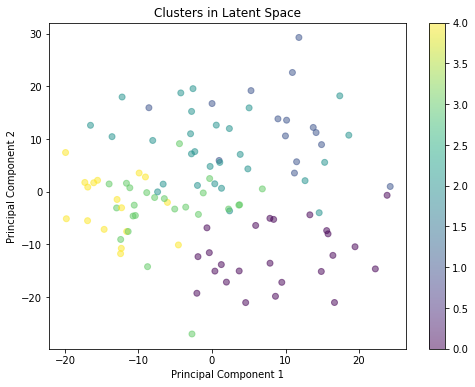

In [94]:
import matplotlib.pyplot as plt

# Scatter plot of the two dimensions
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('Clusters in Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

In [ ]:
# Elbow graph run k-means on diff # of clusters

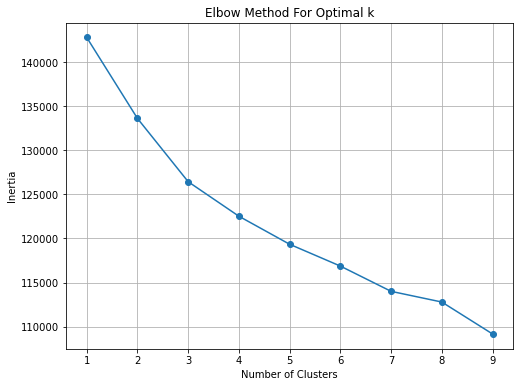

In [101]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate latent representations (assuming `encoder.predict` has been executed)
latent_representations = encoder.predict(normalized_images)

# Range of clusters to try
cluster_range = range(1, 10)  # 1 to 10 clusters
inertia_values = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_representations)
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

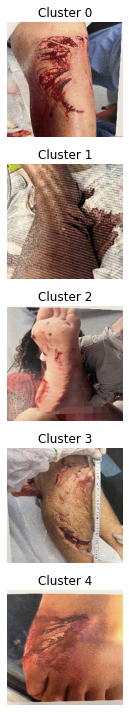

In [100]:
import matplotlib.pyplot as plt

def display_cluster_images(images, labels, n_clusters=5, n_images=1):
    """ Display the first 'n_images' images from each cluster in a grid. """
    fig, axes = plt.subplots(n_clusters, n_images, figsize=(n_images * 2, n_clusters * 2))
    
    for cluster in range(n_clusters):
        # Find indices of images in this cluster
        indices = np.where(labels == cluster)[0]
        if len(indices) == 0:
            continue
        selected_indices = indices[:n_images]  # Get the first 'n_images' images from the cluster
        
        for i, idx in enumerate(selected_indices):
            ax = axes[cluster, i] if n_images > 1 else axes[cluster]
            ax.imshow(images[idx].astype("uint8"))  # Directly use the numpy array for displaying
            ax.axis('off')
            ax.set_title(f'Cluster {cluster}')
    
    plt.tight_layout()
    plt.show()

# Assuming `train_images` is still accessible and contains all your images
# and `cluster_labels` are the labels from your KMeans clustering
# Convert dataset to a list of images (might need adaptation based on your dataset structure)
all_images = list(train_images.unbatch().as_numpy_iterator())

# Display images
display_cluster_images(all_images, cluster_labels, 5)
